In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.linear_model
import sklearn.metrics
from scipy.stats import expon, halfnorm, rayleigh

data = pd.read_csv('eu_ets_rawdata.csv', encoding='latin-1')
data.dropna(inplace=True)
print(data.shape)
data.head()

(443, 6)


,minimum,maximum,mean,median,nbids,nunits
0,64.00,120.0,67.32,66.42,73,49
1,64.48,120.0,67.69,66.57,66,41
2,66.33,120.0,69.22,68.45,83,60
3,66.60,71.0,68.96,69.02,40,8
4,64.81,120.0,67.67,66.76,83,59


In [11]:
bids = data[['minimum', 'maximum', 'mean', 'median']]
M, m = bids.values.max(), bids.values.min()
bids = (bids - m) / (M - m)
for cols in bids.columns:
    data[cols] = bids[cols]
data.head()

,minimum,maximum,mean,median,nbids,nunits
0,0.492269,0.923071,0.517809,0.510885,73,49
1,0.495961,0.923071,0.520655,0.512039,66,41
2,0.510193,0.923071,0.532426,0.526502,83,60
3,0.512270,0.546119,0.530425,0.530887,40,8
4,0.498500,0.923071,0.520502,0.513501,83,59


In [12]:
X = data[['mean']]
y = data['median']

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)


Coefficients: [1.0142779]
Intercept: -0.008128472587843105


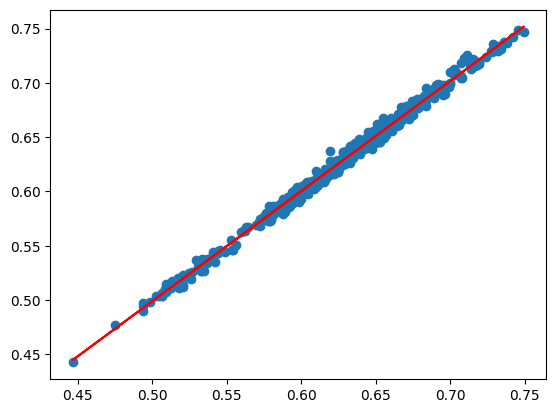

In [13]:
plt.scatter(X, y)
plt.plot(X, model.predict(X), color='red')
plt.show()


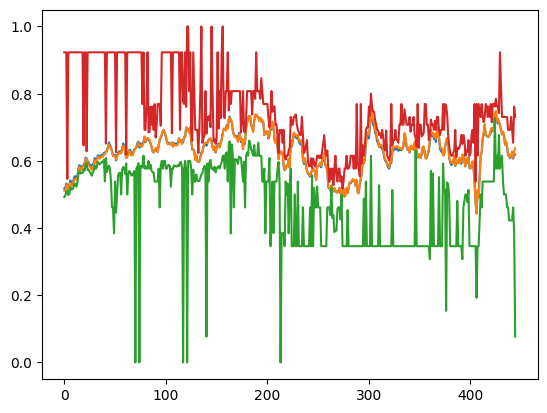

In [14]:
plt.plot(data['mean'])
plt.plot(data['median'])
plt.plot(data['minimum'])
plt.plot(data['maximum'])
plt.show()

In [15]:
def scale(x, m, M, normalize=1):
  if m > M:
    return np.ones(x.shape) * M
  x = (x-x.min())/(x.max()-x.min()+1e-10)

  return m + x * (M - m)

def random_multiply_array(arr):
  m = np.random.randint(1, 11)
  return np.repeat(arr, m), m

In [16]:
for pc in np.linspace(0.8, 0.99, 20):
  L = []
  cnt = 0
  tol = 5
  allbids = {}
  for rows in data.iterrows():
    mi, ma, me, md, nbids, nunits = rows[1]['minimum'], rows[1]['maximum'], rows[1]['mean'], rows[1]['median'], int(rows[1]['nbids']), int(rows[1]['nunits'])
    # print(mi, ma, me, md, nbids, nunits)
    if me > 0.5 * (mi + ma):
      # print("High Bias")
      proxymin = 2*me - ma
      if proxymin < mi:
        bids = np.random.random(nbids)
        bids = scale(bids, mi, ma)
      else:
        pop = int(pc * nbids)
        outliers = nbids - pop
        bids1 = np.random.random(pop)
        bids1 = scale(bids1, proxymin, ma)
        bids2 = np.random.random(outliers)
        bids2 = scale(bids2, mi, proxymin)
        bids = np.concatenate((bids1, bids2))
    else:
      # print("Low Bias")
      proxymax = 2*me - mi
      if proxymax > ma:
        bids = np.random.random(nbids)
        bids = scale(bids, mi, ma)
      else:
        pop = int(pc * nbids)
        outliers = nbids - pop
        bids1 = np.random.random(pop)
        bids1 = scale(bids1, mi, proxymax)
        bids2 = np.random.random(outliers)
        bids2 = scale(bids2, proxymax, ma)
        bids = np.concatenate((bids1, bids2))
    bids, m = random_multiply_array(bids)
    bids = -np.sort(-bids)
    nunits *= m
    if abs(bids.mean()-me)/me * 100 < tol and abs(md-np.median(bids))/md * 100 < tol and nunits >= 100:
      allbids[cnt] = {
          'bids': bids[:nunits],
          'mean_error': abs(bids.mean()-me)/me * 100,
          'median_error': abs(md-np.median(bids))/md * 100,
      }
      cnt += 1
  print(pc, len(allbids))

0.8 207
0.81 209
0.8200000000000001 229
0.8300000000000001 241
0.8400000000000001 259
0.85 295
0.86 302
0.87 320
0.88 323
0.89 343
0.9 324
0.91 309
0.92 349
0.9299999999999999 350
0.94 336
0.95 338
0.96 354
0.97 337
0.98 344
0.99 336


In [17]:
import pickle

# Save the allbids dictionary as a pickle file
with open('allbids_new.pkl', 'wb') as f:
    pickle.dump(allbids, f)

# Read the allbids dictionary from the pickle file
with open('allbids_new.pkl', 'rb') as f:
    allbids = pickle.load(f)
